C:\Users\Tom Li\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


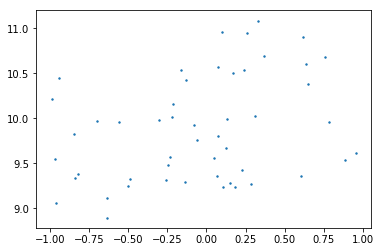

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Data
n = 50
x = np.random.uniform(-1,1,n)
epis = np.random.uniform(-1,1,n)
y = 10 +  0.5*x + epis

plt.scatter(x, y, s = 2)

In [2]:
x = x.reshape(n, 1)
x.shape

(50, 1)

In [3]:
#x = np.column_stack((x, x2))

## Non-Bayesian

In [4]:
# Network parameter
n_inputs = x.shape[1]
n_hidden1 = 1
n_outputs = 1

# tf Graph input
X_tf = tf.placeholder(tf.float32,
                  shape = (None, n_inputs),
                  name = 'X')
y_tf = tf.placeholder(tf.float32,
                  shape = (None),
                  name = 'y')

# Paraameters
learning_rate = 0.1
num_steps = 400
batch_size = 100
display_step = 50

# Layer weights and bias
weights = {
    'out': tf.Variable(tf.random_normal([n_inputs, n_outputs]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_outputs])), 
}

# Model
def neural_net(x):
    out_layer = tf.add(tf.matmul(x, weights['out']), biases['out'])
    
    return out_layer

In [5]:
# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model

# Initialize the variables
init = tf.global_variables_initializer()

In [6]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #batch_x = np.random.choice(x[:,0], batch_size).reshape(batch_size, 1)
        #batch_y = np.random.choice(y, batch_size)
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred = sess.run(NN, feed_dict={X_tf: x})


step 1, Minibatch Loss = 81.89804
step 50, Minibatch Loss = 20.846054
step 100, Minibatch Loss = 3.0050826
step 150, Minibatch Loss = 0.46307263
step 200, Minibatch Loss = 0.3023025
step 250, Minibatch Loss = 0.29853532
step 300, Minibatch Loss = 0.29851598
step 350, Minibatch Loss = 0.29851595
step 400, Minibatch Loss = 0.29851592
optimization finished


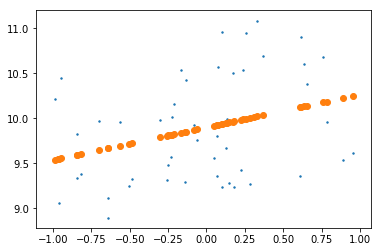

In [7]:
plt.scatter(x[:,0], y, s = 2)
plt.scatter(x[:,0], pred)


## Bayesian

In [8]:
neural_net = tf.keras.Sequential([
    tfp.layers.DenseFlipout(1)
])

# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
# ELBO!!!!!!!!!!!!
neg_log_likelihood  = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))

kl = sum(neural_net.losses)/n
loss_op = neg_log_likelihood + kl

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables
init = tf.global_variables_initializer()

In [9]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred_mean = sess.run(NN, feed_dict={X_tf: x})
    
    # Draw sample for the weights and bias from the posterior
    w0_draw = neural_net.layers[0].kernel_posterior.sample(1000).eval()
    #w1_draw = neural_net.layers[1].kernel_posterior.sample(100).eval()
    #w2_draw = neural_net.layers[2].kernel_posterior.sample(100).eval()
    b0_draw = neural_net.layers[0].bias_posterior.sample(1000).eval()
    #b1_draw = neural_net.layers[1].bias_posterior.sample(100).eval()
    #b2_draw = neural_net.layers[2].bias_posterior.sample(100).eval()



step 1, Minibatch Loss = 92.18112
step 50, Minibatch Loss = 26.257374
step 100, Minibatch Loss = 4.447861
step 150, Minibatch Loss = 0.67594033
step 200, Minibatch Loss = 0.34017327
step 250, Minibatch Loss = 0.32232168
step 300, Minibatch Loss = 0.33183584
step 350, Minibatch Loss = 0.32698014
step 400, Minibatch Loss = 0.3419287
optimization finished


In [10]:
def np_relu(x):
    return np.maximum(x, 0)

pred = []
for i in range(100):
    pred.append(x.dot(w0_draw[i])+b0_draw[i])

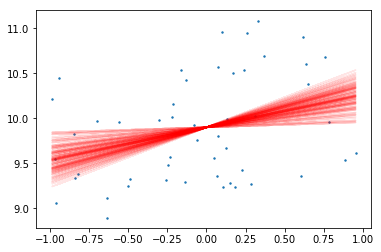

In [11]:
plt.scatter(x[:,0], y, s = 2)
for i in range(100):
    plt.plot(x[:,0], pred[i], c = 'r', alpha = 0.1)
#plt.scatter(x[:,0], pred_mean, c = 'g')





(0, 1)

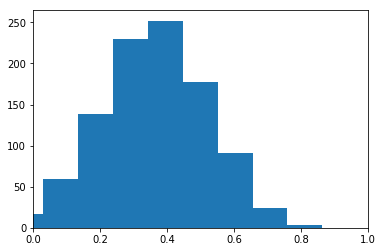

In [12]:
plt.hist(w0_draw[:,0])
plt.xlim(0,1)


(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([ 9.40002823,  9.50002823,  9.60002823,  9.70002823,  9.80002823,
         9.90002823, 10.00002823, 10.10002823, 10.20002823, 10.30002823,
        10.40002823]),
 <a list of 10 Patch objects>)

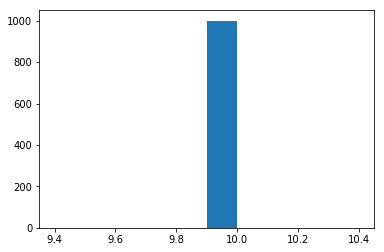

In [13]:
plt.hist(b0_draw[:,0])